https://www.youtube.com/watch?v=hK-qUy3UfT8

In [1]:
# file: load_all.py
import sqlite3
import pandas as pd
from pathlib import Path

DB = "ecommerce.db"

# Какие файлы грузим: имя файла -> имя таблицы и настройки чтения
FILES = {
    "customers.csv":   {"table": "customers",   "parse_dates": []},
    "geolocation.csv": {"table": "geolocation", "parse_dates": []},
    "order_items.csv": {"table": "order_items", "parse_dates": []},
    "orders.csv":      {"table": "orders",      "parse_dates": ["order_purchase_timestamp",
                                                                "order_approved_at",
                                                                "order_delivered_carrier_date",
                                                                "order_delivered_customer_date",
                                                                "order_estimated_delivery_date"]},
    "payments.csv":    {"table": "payments",    "parse_dates": []},
    "products.csv":    {"table": "products",    "parse_dates": []},
    "sellers.csv":     {"table": "sellers",     "parse_dates": []},
}

def load_csv_to_sql(conn, csv_path: Path, table: str, parse_dates, chunksize=150_000):
    """
    Грузим CSV в таблицу table. Для крупных файлов используем chunksize.
    """
    print(f"-> Loading {csv_path.name} into table {table} ...")
    # Пытаемся прочитать целиком; если не хватает памяти — читаем чанками
    try:
        df = pd.read_csv(csv_path, parse_dates=[c for c in parse_dates if c in pd.read_csv(csv_path, nrows=0).columns])
        df.to_sql(table, conn, if_exists="replace", index=False)
    except Exception:
        # Чтение чанками (надёжно для больших файлов)
        cols = pd.read_csv(csv_path, nrows=0).columns.tolist()
        date_cols = [c for c in parse_dates if c in cols]
        first = True
        for chunk in pd.read_csv(csv_path, chunksize=chunksize, parse_dates=date_cols):
            chunk.to_sql(table, conn, if_exists="replace" if first else "append", index=False)
            first = False
    print(f"   Done: {table}")

def create_indexes(conn):
    """
    Полезные индексы для ускорения JOIN/WHERE.
    Не падаем, если колонок нет в конкретной версии датасета.
    """
    cur = conn.cursor()
    statements = [
        "CREATE INDEX IF NOT EXISTS idx_customers_id   ON customers(customer_id);",
        "CREATE INDEX IF NOT EXISTS idx_customers_zip  ON customers(customer_zip_code_prefix);",
        "CREATE INDEX IF NOT EXISTS idx_orders_id      ON orders(order_id);",
        "CREATE INDEX IF NOT EXISTS idx_orders_cust    ON orders(customer_id);",
        "CREATE INDEX IF NOT EXISTS idx_orders_time    ON orders(order_purchase_timestamp);",
        "CREATE INDEX IF NOT EXISTS idx_items_order    ON order_items(order_id);",
        "CREATE INDEX IF NOT EXISTS idx_items_product  ON order_items(product_id);",
        "CREATE INDEX IF NOT EXISTS idx_pay_order      ON payments(order_id);",
        "CREATE INDEX IF NOT EXISTS idx_products_id    ON products(product_id);",
        "CREATE INDEX IF NOT EXISTS idx_sellers_id     ON sellers(seller_id);",
        "CREATE INDEX IF NOT EXISTS idx_geo_zip        ON geolocation(geolocation_zip_code_prefix);",
    ]
    for s in statements:
        try:
            cur.execute(s)
        except sqlite3.OperationalError:
            pass
    conn.commit()

def main():
    here = Path(".")
    with sqlite3.connect(DB) as conn:
        conn.execute("PRAGMA foreign_keys = ON;")

        # Загрузка всех файлов, что реально лежат рядом
        for fname, cfg in FILES.items():
            p = here / fname
            if p.exists():
                load_csv_to_sql(conn, p, cfg["table"], cfg["parse_dates"])
            else:
                print(f"!! Skipped (not found): {fname}")

        create_indexes(conn)

if __name__ == "__main__":
    main()

-> Loading customers.csv into table customers ...
   Done: customers
-> Loading geolocation.csv into table geolocation ...
   Done: geolocation
-> Loading order_items.csv into table order_items ...
   Done: order_items
-> Loading orders.csv into table orders ...
   Done: orders
-> Loading payments.csv into table payments ...
   Done: payments
-> Loading products.csv into table products ...
   Done: products
-> Loading sellers.csv into table sellers ...
   Done: sellers


# List all unique cities where customers are located.

In [2]:
DB_PATH = "ecommerce.db"

with sqlite3.connect(DB_PATH) as conn:
    cur = conn.cursor()
    cur.execute("SELECT DISTINCT customer_city FROM customers;")
    cities = [row[0] for row in cur.fetchall()]
cities

['franca',
 'sao bernardo do campo',
 'sao paulo',
 'mogi das cruzes',
 'campinas',
 'jaragua do sul',
 'timoteo',
 'curitiba',
 'belo horizonte',
 'montes claros',
 'rio de janeiro',
 'lencois paulista',
 'caxias do sul',
 'piracicaba',
 'guarulhos',
 'pacaja',
 'florianopolis',
 'aparecida de goiania',
 'santo andre',
 'goiania',
 'cachoeiro de itapemirim',
 'sao jose dos campos',
 'sao roque',
 'camacari',
 'resende',
 'sumare',
 'novo hamburgo',
 'sao luis',
 'sao jose',
 'santa barbara',
 'ribeirao preto',
 'ituiutaba',
 'taquarituba',
 'sao jose dos pinhais',
 'barrinha',
 'parati',
 'dourados',
 'trindade',
 'cascavel',
 'fortaleza',
 'brasilia',
 'pelotas',
 'porto alegre',
 'salto',
 'jundiai',
 'cacapava',
 'sao vicente',
 'uberlandia',
 'botelhos',
 'sao goncalo',
 'araucaria',
 'nova iguacu',
 'areia branca',
 'campos dos goytacazes',
 'sao carlos',
 'itajuba',
 'cruz das almas',
 'vassouras',
 'feira de santana',
 'niteroi',
 'sobral',
 'divinopolis',
 'paraiba do sul',
 '

# Count the number of orders placed in 2017.

In [3]:
with sqlite3.connect(DB_PATH) as conn:
    cur = conn.cursor()
    cur.execute(""" SELECT COUNT(order_id) FROM orders WHERE strftime('%Y', order_purchase_timestamp) = '2017'; """)
    count_2017 = [row[0] for row in cur.fetchall()]
count_2017[0]

45101

# Find the total Sales per category.

In [4]:
payments = pd.read_csv('payments.csv')
payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [5]:
products = pd.read_csv('products.csv')
products.head()

,product_id,product category,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumery,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,Art,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,sport leisure,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,babies,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,housewares,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [6]:
orders = pd.read_csv("orders.csv")
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [7]:
sql = """
SELECT
  UPPER(products.'product category'),
  ROUND(SUM(payments.payment_value), 2)
FROM products
JOIN order_items
  ON products.product_id = order_items.product_id
JOIN payments
  ON payments.order_id = order_items.order_id
GROUP BY products.'product category'
"""

with sqlite3.connect(DB_PATH) as conn:
    cur = conn.cursor()
    cur.execute(sql)
    rows = cur.fetchall()
total = pd.DataFrame(rows, columns=["Category", "Sales"])
total.head(10)

,Category,Sales
0,None,252801.71
1,AGRO INDUSTRIA E COMERCIO,118730.61
2,ART,30992.93
3,ARTS AND CRAFTS,2326.17
4,BAGS ACCESSORIES,187151.29
5,BLU RAY DVDS,7935.28
6,CITTE AND UPHACK FURNITURE,5998.54
7,CONSTRUCTION SECURITY TOOLS,65691.03
8,CASA CONSTRUCAO,136645.29
9,CHRISTMAS ARTICLES,18994.77


# Calculate the numbers of orders that were paid in installments.

In [8]:
sql = """
SELECT 
    ROUND(100.0 * SUM(CASE WHEN payment_installments >= 1 THEN 1 ELSE 0 END) / COUNT(*), 3)
FROM payments;
"""

with sqlite3.connect(DB_PATH) as conn:
    cur = conn.cursor()
    cur.execute(sql)
    data = cur.fetchall()
data[0]

(99.998,)

# Count the number of customers from each state.

In [9]:
customers = pd.read_csv('customers.csv')
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [18]:
sql = """
SELECT customer_state, COUNT(customer_id) AS costumers_number FROM customers GROUP BY customer_state;
"""

with sqlite3.connect(DB_PATH) as conn:
    cur = conn.cursor()
    cur.execute(sql)
    data = cur.fetchall()
total = pd.DataFrame(data, columns=["State", "Number of Customers"])
total = total.sort_values(by = "Number of Customers", ascending = False)
total.head(10)

,State,Number of Customers
25,SP,41746
18,RJ,12852
10,MG,11635
22,RS,5466
17,PR,5045
23,SC,3637
4,BA,3380
6,DF,2140
7,ES,2033
8,GO,2020


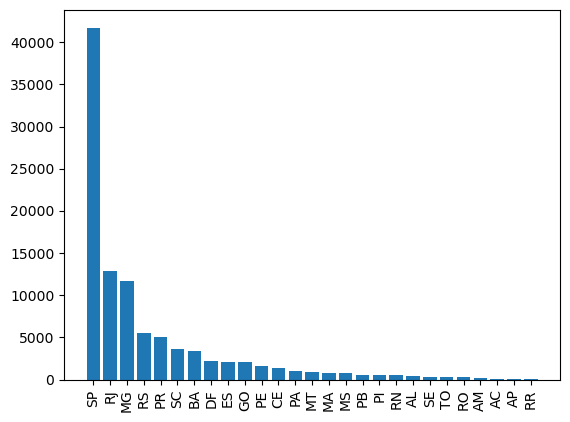

In [23]:
import matplotlib.pyplot as plt

plt.bar(total['State'], total['Number of Customers'])
plt.xticks(rotation = 90)
plt.show()

# Calculate the number of orders per month in 2018.

In [24]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [42]:
sql = """
SELECT
  CASE strftime('%m', order_purchase_timestamp)
    WHEN '01' THEN 'Jan'
    WHEN '02' THEN 'Feb'
    WHEN '03' THEN 'Mar'
    WHEN '04' THEN 'Apr'
    WHEN '05' THEN 'May'
    WHEN '06' THEN 'Jun'
    WHEN '07' THEN 'Jul'
    WHEN '08' THEN 'Aug'
    WHEN '09' THEN 'Sep'
    WHEN '10' THEN 'Oct'
    WHEN '11' THEN 'Nov'
    WHEN '12' THEN 'Dec'
  END AS month_name,
  COUNT(order_id) AS n_orders
FROM orders
WHERE strftime('%Y', order_purchase_timestamp) = '2018'
GROUP BY month_name
ORDER BY n_orders;
"""

with sqlite3.connect(DB_PATH) as conn:
    cur = conn.cursor()
    cur.execute(sql)
    data = cur.fetchall()
total = pd.DataFrame(data, columns=["Month", "Number of Orders"])
total

,Month,Number of Orders
0,Oct,4
1,Sep,16
2,Jun,6167
3,Jul,6292
4,Aug,6512
5,Feb,6728
6,May,6873
7,Apr,6939
8,Mar,7211
9,Jan,7269


<Axes: xlabel='Month', ylabel='Number of Orders'>

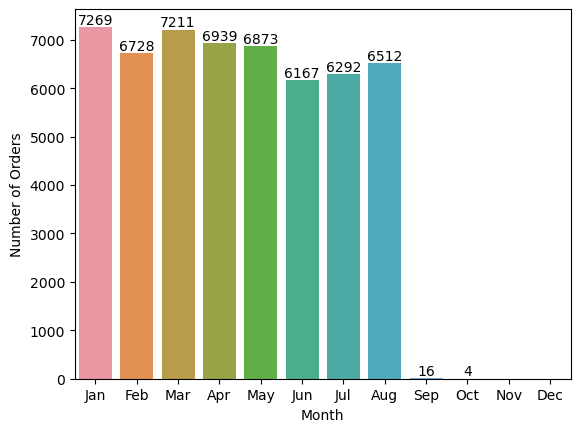

In [51]:
import seaborn as sns

order_of_months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
ax = sns.barplot(x = total['Month'], y = total['Number of Orders'], data = total, order = order_of_months)
ax.bar_label(ax.containers[0])
ax

# Find the average number of products per order, grouped by customer city.

In [55]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [56]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [58]:
order_items = pd.read_csv('order_items.csv')
order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [75]:
sql = """
SELECT
  customers.customer_city,
  AVG(oi_per_order.n_items * 1.0) AS avg_items_per_order
FROM customers
JOIN orders 
  ON orders.customer_id = customers.customer_id
JOIN (
  SELECT order_items.order_id, COUNT(*) AS n_items
  FROM order_items
  GROUP BY order_items.order_id
) AS oi_per_order
  ON oi_per_order.order_id = orders.order_id
GROUP BY customers.customer_city;

"""

with sqlite3.connect(DB_PATH) as conn:
    cur = conn.cursor()
    cur.execute(sql)
    data = cur.fetchall()
total = pd.DataFrame(data, columns=["Customer City", "Number of Products"])
total = total.sort_values(by = "Number of Products", ascending = False)
total.head(10)

,Customer City,Number of Products
0,padre carvalho,7.0
1,celso ramos,6.5
2,datas,6.0
3,candido godoi,6.0
4,matias olimpio,5.0
5,teixeira soares,4.0
6,picarra,4.0
7,morro de sao paulo,4.0
8,curralinho,4.0
9,cidelandia,4.0


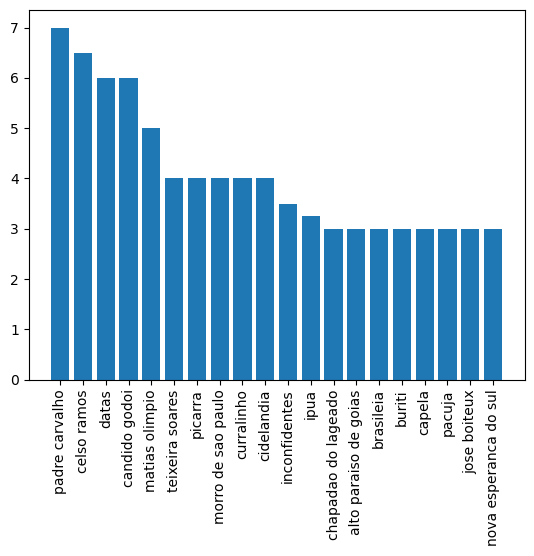

In [76]:
plt.bar(total['Customer City'][:20], total['Number of Products'][:20])
plt.xticks(rotation=90)
plt.show()

# Calculate the percentage of total revenue contributed by each product category.

In [78]:
payments = pd.read_csv('payments.csv')

payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [79]:
products.head()

,product_id,product category,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumery,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,Art,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,sport leisure,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,babies,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,housewares,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [81]:
order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [85]:
sql = """
SELECT
  products."product category" AS category,
  SUM(order_items.price),
  ROUND(100.0 * SUM(order_items.price) / (SELECT SUM(price) FROM order_items), 2) AS pct_of_total
FROM products
JOIN order_items ON order_items.product_id = products.product_id
GROUP BY category
ORDER BY pct_of_total DESC;
"""

with sqlite3.connect(DB_PATH) as conn:
    cur = conn.cursor()
    cur.execute(sql)
    data = cur.fetchall()
total = pd.DataFrame(data)
total.head(10)

,0,1,2
0,HEALTH BEAUTY,1258681.34,9.26
1,Watches present,1205005.68,8.87
2,bed table bath,1036988.68,7.63
3,sport leisure,988048.97,7.27
4,computer accessories,911954.32,6.71
5,Furniture Decoration,729762.49,5.37
6,Cool Stuff,635290.85,4.67
7,housewares,632248.66,4.65
8,automotive,592720.11,4.36
9,Garden tools,485256.46,3.57


In [91]:
import matplotlib.pyplot as plt

# Берём первые 10 строк (если нужно все — убери [:10])
labels = total[0].head(10)
values = total[2].head(10)

plt.figure(figsize=(6, 6))
plt.pie(
    values,
    labels=total[0],
    autopct='%1.1f%%',
    startangle=90,
    counterclock=False
)
plt.axis('equal')  # чтобы круг не был овальным
plt.title('Percentage of Total Revenue by Product Category')
plt.tight_layout()
plt.show()


TypeError: pie() got an unexpected keyword argument 'values'

<Figure size 500x500 with 0 Axes>